# GPLearn for Image Synthesis

## Imports

In [1]:
from gplearn.genetic import SymbolicRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import graphviz
from sklearn.metrics import make_scorer
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from gplearn.fitness import make_fitness
import os
import pickle
import sys
from utils.comparison import *
import contextlib
from PIL import Image

from utils.vis import *

In [2]:
GENERATIONS= 10
POP_SIZE = 1000

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Data

In [4]:
def safe_exp_exp(val):
    val = np.where(val > 700, 700, val)
    return np.exp(-np.exp(val))

def precalculate_xy(x, y):
    x2_y2 = x**2 + y**2
    sin_x = np.sin(x)
    cos_y = np.cos(y)
    sin_03x_07y = np.sin(0.3 * x - 0.7 * y)
    sin_03x_05y = np.sin(0.3 * x + 0.5 * y)
    return {
        "x2_y2": x2_y2,
        "sin_x": sin_x,
        "cos_y": cos_y,
        "sin_combo1": sin_03x_07y,
        "sin_combo2": sin_03x_05y
    }

def precalculate_D_B(cache):
    D_val = safe_exp_exp(cache["x2_y2"] - 1089)
    B_val = safe_exp_exp(cache["x2_y2"] - 1225) * \
            safe_exp_exp(-1000 * (cache["sin_combo1"] + 4 * cache["sin_combo2"]))
    return D_val, B_val

def Jc(D_val, B_val, cache, c):
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(cache["x2_y2"] - (cache["x2_y2"] - cache["x2_y2"] + 20_000))
    exp2 = safe_exp_exp(-20 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp1 * exp2

def Ic(D_val, B_val, cache, c):
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp

def Hc(D_val, B_val, c):
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * B_val + (1 - B_val) * 0.93 * D_val

def Ac(x, y, c):
    cache = precalculate_xy(x, y)
    D_val, B_val = precalculate_D_B(cache)
    return 255 * (Hc(D_val, B_val, c) + Ic(D_val, B_val, cache, c) + Jc(D_val, B_val, cache, c))

def rgb(x, y, c):
    return Ac((x - 800) / 10, (500 - y) / 10, c)

In [5]:
width, height = 1600, 1000

m = np.linspace(1, width, width//5)
n = np.linspace(1, height, height//5)
m_grid, n_grid = np.meshgrid(m, n)

r = rgb(m_grid, n_grid, 1)
g = rgb(m_grid, n_grid, 2)
b = rgb(m_grid, n_grid, 3)

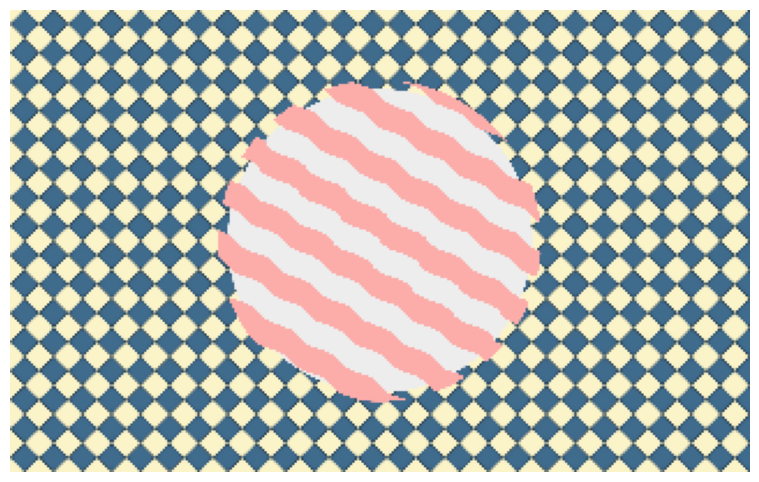

In [6]:
rgb_image = np.stack([r, g, b], axis=-1).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.axis('off')
plt.savefig('data/hard_2.png')
plt.show()

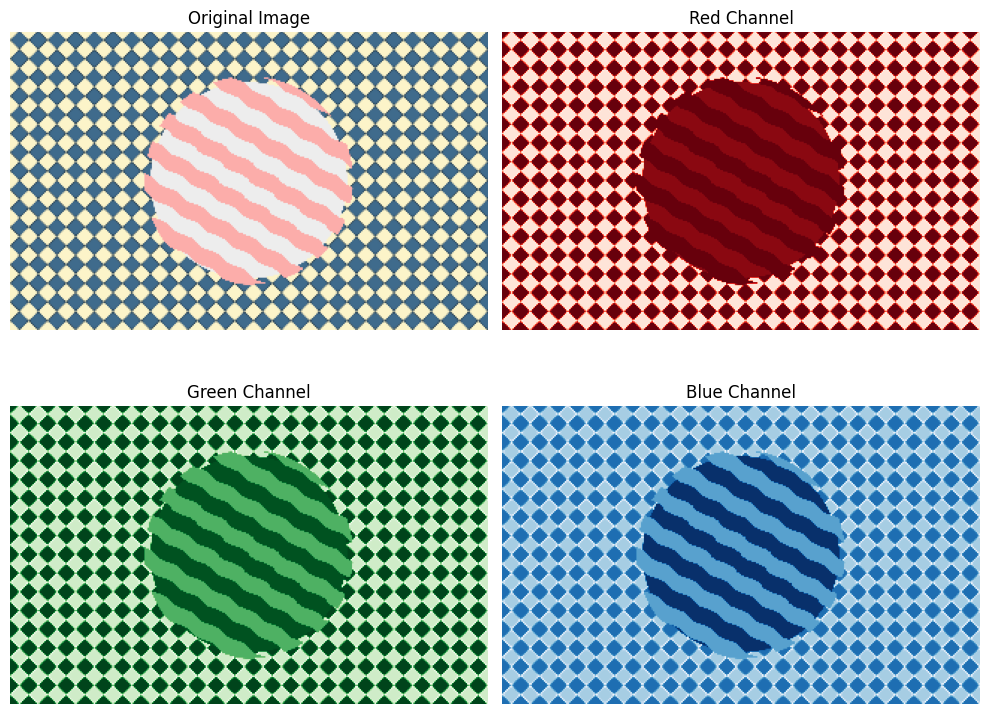

In [7]:
plt.figure(figsize=(10, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')
plt.axis('off')

# Red channel
plt.subplot(2, 2, 2)
plt.imshow(r, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(2, 2, 3)
plt.imshow(g, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(2, 2, 4)
plt.imshow(b, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

## Experiments

In [8]:
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = os.dup(2)
        os.dup2(devnull.fileno(), 2)
        try:
            yield
        finally:
            os.dup2(old_stderr, 2)
            os.close(old_stderr)

In [9]:
np.seterr(divide='ignore', invalid='ignore')

def safe_sin(x):
    return np.sin(np.clip(x, -1e3, 1e3))

def safe_cos(x):
    return np.cos(np.clip(x, -1e3, 1e3))

def safe_square(x):
    return np.clip(x, -1e3, 1e3) ** 2

def safe_cube(x):
    return np.clip(x, -1e3, 1e3) ** 3

def safe_exp(x):
    x = np.where(x > 700, 700, x)
    return np.exp(x)

def x2_y2(x, y):
    return np.clip(x**2 + y**2, 0, 1e7)

def sin_03x_07y(x, y):
    return np.sin(np.clip(0.3 * x - 0.7 * y,  -1e3, 1e3))

def sin_03x_05y(x, y):
    return np.sin(np.clip(0.3 * x + 0.5 * y,  -1e3, 1e3))

def x_db_func(x, y):
    return safe_exp_exp(x2_y2(x, y) - 1089)

def y_db_func(x, y):
    return safe_exp_exp(x2_y2(x, y) - 1225) * safe_exp_exp(-1000 * (sin_03x_07y(x,y) + 4 * sin_03x_05y(x, y)))

# Red

def jcr_func(d_val, b_val, x, y):
    c=1
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(x2_y2(x, y) - (x2_y2(x, y) - x2_y2(x, y) + 20_000))
    exp2 = safe_exp_exp(-20 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp1 * exp2

def icr_func(d_val, b_val, x, y):
    c=1
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp

def hcr_func(x, y):
    c=1
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * y + (1 - y) * 0.93 * x

def acr_func(x, y):
    x = (x - 800) / 10
    y = (500 - y) / 10
    D_val = x_db_func(x, y)
    B_val = y_db_func(x, y)
    return 255 * (hcr_func(D_val, B_val) + icr_func(D_val, B_val, x, y) + jcr_func(D_val, B_val, x, y))

# Greem
def jcg_func(d_val, b_val, x, y):
    c=2
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(x2_y2(x, y) - (x2_y2(x, y) - x2_y2(x, y) + 20_000))
    exp2 = safe_exp_exp(-20 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp1 * exp2

def icg_func(d_val, b_val, x, y):
    c=2
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp

def hcg_func(x, y):
    c=2
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * y + (1 - y) * 0.93 * x

def acg_func(x, y):
    x = (x - 800) / 10
    y = (500 - y) / 10
    D_val = x_db_func(x, y)
    B_val = y_db_func(x, y)
    return 255 * (hcg_func(D_val, B_val) + icg_func(D_val, B_val, x, y) + jcg_func(D_val, B_val, x, y))

# Blue
def jcb_func(d_val, b_val, x, y):
    c=3
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(x2_y2(x, y) - (x2_y2(x, y) - x2_y2(x, y) + 20_000))
    exp2 = safe_exp_exp(-20 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp1 * exp2

def icb_func(d_val, b_val, x, y):
    c=3
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp

def hcb_func(x, y):
    c=3
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * y + (1 - y) * 0.93 * x

def acb_func(x, y):
    x = (x - 800) / 10
    y = (500 - y) / 10
    D_val = x_db_func(x, y)
    B_val = y_db_func(x, y)
    return 255 * (hcb_func(D_val, B_val) + icb_func(D_val, B_val, x, y) + jcb_func(D_val, B_val, x, y))

def mul_255(x):
    return 255*x

def rescale_x(x):
    return (x - 800) / 10

def rescale_y(y):
    return (500 - y) / 10 

exp = make_function(function=safe_exp, name="exp", arity=1)
exp_exp = make_function(function=safe_exp_exp, name="exp_exp", arity=1)
sin = make_function(function=safe_sin, name="sin", arity=1)
cos = make_function(function=safe_cos, name="cos", arity=1)
square = make_function(function=safe_square, name="square", arity=1)
cube = make_function(function=safe_cube, name="cube", arity=1)
x2_y2_func = make_function(function=x2_y2, name="x2y2", arity=2)
sin_03x_07y_func = make_function(function=sin_03x_07y, name="sin_03x_07y", arity=2)
sin_03x_05y_func = make_function(function=sin_03x_05y, name="sin_03x_05y", arity=2)
xdb = make_function(function=x_db_func, name="x_db_func", arity=2)
ydb = make_function(function=y_db_func, name="y_db_func", arity=2)

jccr = make_function(function=jcr_func, name="jcr_func", arity=4)
iccr = make_function(function=icr_func, name="icr_func", arity=4)
hccr = make_function(function=hcr_func, name="hcr_func", arity=2)
accr = make_function(function=acr_func, name="acr_func", arity=2)

jccg = make_function(function=jcg_func, name="jcg_func", arity=4)
iccg = make_function(function=icg_func, name="icg_func", arity=4)
hccg = make_function(function=hcg_func, name="hcg_func", arity=2)
accg = make_function(function=acg_func, name="acg_func", arity=2)

jccb = make_function(function=jcb_func, name="jcb_func", arity=4)
iccb = make_function(function=icb_func, name="icb_func", arity=4)
hccb = make_function(function=hcb_func, name="hcb_func", arity=2)
accb = make_function(function=acb_func, name="acb_func", arity=2)

rescale_x_func = make_function(function=rescale_x, name="res_x", arity=1)
rescale_y_func = make_function(function=rescale_y, name="res_y", arity=1)
multipy_255 = make_function(function=mul_255, name="mul_255", arity=1)

def _SSIM(y, y_pred, w):
    if len(y) < 7:
        return -100
    y_pred = np.clip(y_pred, a_min=0, a_max=256)
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    y_pred_img = y_pred.reshape((H, W))
    y_img = y.reshape((H, W))
    return ssim(y_img, y_pred_img, full=True, data_range=256)[0]

ssim_fitness = make_fitness(function=_SSIM, greater_is_better=True)

def combined_ssim_mae(y, y_pred, sample_weight):
    if len(y) < 7:
        return -100  # Disqualify tiny inputs
    
    # Clamp and clean
    y_pred = np.clip(y_pred, a_min=0, a_max=256)
    y_pred = np.nan_to_num(y_pred, nan=0.0)

    try:
        y_pred_img = y_pred.reshape((H, W))
        y_img = y.reshape((H, W))
    except:
        return -100  # Reshape error fallback

    ssim_score = ssim(y_img, y_pred_img, data_range=256)
    mae = np.mean(np.abs(y - y_pred))

    # Combine: SSIM is in [0,1], MAE in [0,256]; normalize if needed
    alpha = 1.0  # weight for SSIM
    beta = 0.01  # weight for MAE (scaling because MAE can be large)

    score = alpha * ssim_score - beta * mae  # maximize SSIM, minimize MAE
    return score

# Register with gplearn
combined_fitness = make_fitness(function=combined_ssim_mae, greater_is_better=True)

#function_set = ['add', 'sub', 'mul', sin, cos, square, cube, exp, exp_exp, x2_y2_func, sin_03x_05y_func, sin_03x_07y_func, jcc, xdb, ydb, icc, hcc, acc]
function_setr = ['add', jccr, xdb, ydb, iccr, hccr, multipy_255, rescale_x_func, rescale_y_func]
function_setg = ['add', jccg, xdb, ydb, iccg, hccg, multipy_255, rescale_x_func, rescale_y_func]
function_setb = ['add', jccb, xdb, ydb, iccb, hccb, multipy_255, rescale_x_func, rescale_y_func]
#function_setr = [accr]

est_r = SymbolicRegressor(metric=combined_fitness, function_set=function_setr, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=1.0,
        verbose=1, random_state=42, n_jobs=8, init_method='half and half', const_range = None, init_depth=(3, 6))

est_g = SymbolicRegressor(metric=combined_fitness, function_set=function_setg, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=1.0,
        verbose=1, random_state=42, n_jobs=8, init_method='half and half', const_range = None, init_depth=(3, 6))

est_b = SymbolicRegressor(metric=combined_fitness, function_set=function_setb, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=1.0,
        verbose=1, random_state=42, n_jobs=8, init_method='half and half', const_range = None, init_depth=(3, 6))


H, W, _ = rgb_image.shape

arr = []

x = np.arange(1, W + 1)
y = np.arange(1, H + 1)
X, Y = np.meshgrid(x, y)
xy_train = np.stack((m_grid.flatten(), n_grid.flatten()), axis=1)

r_train = xy_train
g_train = xy_train
b_train = xy_train

r = r.flatten()
g = g.flatten()
b = b.flatten()

In [10]:
print(f"Training Red SSIM MAE: \n")
est_r.fit(r_train, r)

print(f"Training Green SSIM MAE: \n")
est_g.fit(g_train, g)

print(f"Training Blue SSIM MAE: \n")
est_b.fit(b_train, b)

Training Red SSIM MAE: 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    62.76         -1.52748       22        -0.578477              N/A      1.78m
   1    23.38        -0.990659       50        -0.466977              N/A     36.37s
   2     9.10        -0.888352       53        -0.456177              N/A     25.92s
   3    27.99         -0.82999       17         0.126834              N/A     36.57s
   4    49.36        -0.643191       17         0.146058              N/A     54.39s
   5    50.69        -0.539613       17         0.146058              N/A     58.18s
   6    37.07        -0.468029       17         0.146287              N/A     54.37s
   7    23.15        -0.517912       17         0.146287              N/A     29.23s
   8    18.51        -0.593354       14         0.

SymbolicRegressor(const_range=None,
                  function_set=['add',
                                <gplearn.functions._Function object at 0x000002D752052750>,
                                <gplearn.functions._Function object at 0x000002D752053BD0>,
                                <gplearn.functions._Function object at 0x000002D752053A50>,
                                <gplearn.functions._Function object at 0x000002D752052650>,
                                <gplearn.functions._Function object at 0x000002D752051190>,
                                <gplearn.functions._Function object at 0x000002D752050A10>,
                                <gplearn.functions._Function object at 0x000002D752052510>,
                                <gplearn.functions._Function object at 0x000002D7520531D0>],
                  generations=10, init_depth=(3, 6),
                  metric=<gplearn.fitness._Fitness object at 0x000002D752053DD0>,
                  n_jobs=8, random_state=42, stopping_criteria=1.0, verbose=1)

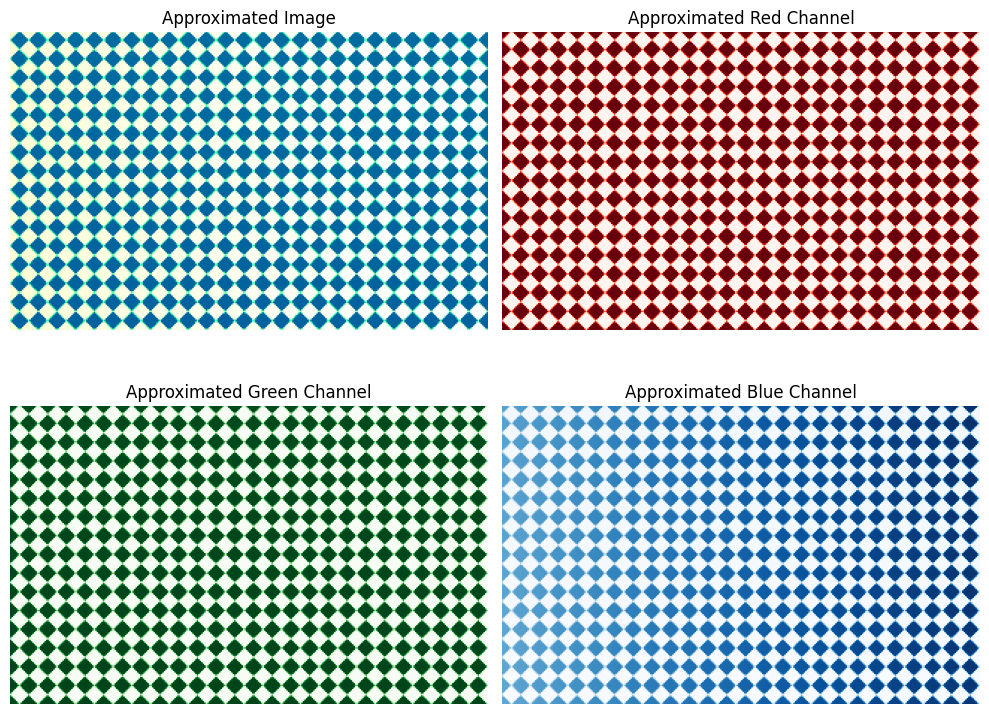

In [11]:
plot_results((est_r, est_g, est_b), xy_train, rgb_image.shape)

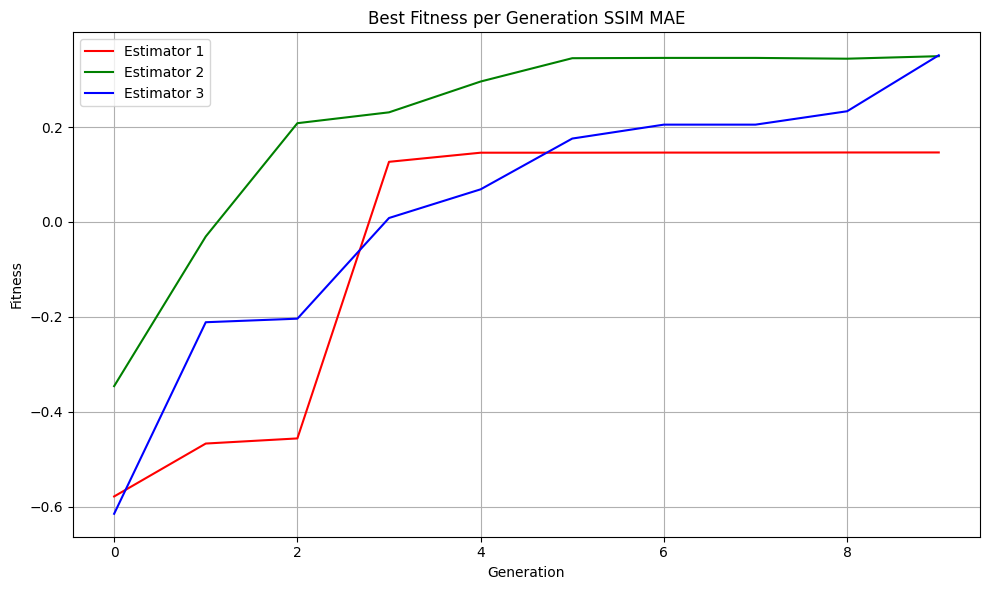

In [12]:
plot_fitness((est_r, est_g, est_b), 0, "SSIM MAE")

In [13]:
# # Change metric
# est_r.set_params(metric = 'mean absolute error', generations = 20, warm_start = True)
# est_g.set_params(metric = 'mean absolute error', generations = 20, warm_start = True)
# est_b.set_params(metric = 'mean absolute error', generations = 20, warm_start = True)

# print(f"Training Red MAE: \n")
# est_r.fit(r_train, r)

# print(f"Training Green MAE: \n")
# est_g.fit(g_train, g)

# print(f"Training Blue MAE: \n")
# est_b.fit(b_train, b)

In [14]:
print(est_r._program)

mul_255(jcr_func(x_db_func(res_x(X1), X1), x_db_func(res_y(X1), X1), res_x(X0), res_y(X1)))


In [15]:
print(est_g._program)

add(add(jcg_func(res_y(res_y(res_x(X1))), res_y(res_x(y_db_func(X1, X0))), X0, X1), res_y(res_x(X1))), res_y(y_db_func(X1, X0)))


In [16]:
print(est_b._program)

res_y(res_y(add(jcb_func(res_y(res_y(res_x(res_y(res_x(X0))))), res_y(res_y(mul_255(res_y(res_y(res_x(jcb_func(X0, res_y(res_x(X0)), X1, X0))))))), X0, X1), mul_255(res_y(res_y(res_y(X1)))))))


In [17]:
dot_data = est_r._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [18]:
dot_data = est_g._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [19]:
dot_data = est_b._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [20]:
est_r.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [21]:
est_g.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [22]:
est_b.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])